In [12]:
!pip install tensorflow


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.20.0


In [5]:
# Inside Docker, dataset is here:
DATA_DIR = Path("/app/data/processed")

TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

print("Train Directory:", TRAIN_DIR)
print("Val Directory:", VAL_DIR)
print("Test Directory:", TEST_DIR)


Train Directory: /app/data/processed/train
Val Directory: /app/data/processed/val
Test Directory: /app/data/processed/test


In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

test_data = val_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

num_classes = len(train_data.class_indices)
print("Classes:", train_data.class_indices)


Found 18750 images belonging to 15 classes.
Found 5722 images belonging to 15 classes.
Found 5718 images belonging to 15 classes.
Classes: {'Pepper__bell___Bacterial_spot': 0, 'Pepper__bell___healthy': 1, 'Potato___Early_blight': 2, 'Potato___Late_blight': 3, 'Potato___healthy': 4, 'Tomato_Bacterial_spot': 5, 'Tomato_Early_blight': 6, 'Tomato_Late_blight': 7, 'Tomato_Leaf_Mold': 8, 'Tomato_Septoria_leaf_spot': 9, 'Tomato_Spider_mites_Two_spotted_spider_mite': 10, 'Tomato__Target_Spot': 11, 'Tomato__Tomato_YellowLeaf__Curl_Virus': 12, 'Tomato__Tomato_mosaic_virus': 13, 'Tomato_healthy': 14}


In [7]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,895 (42.61 MB)

 Trainable params: 11,170,895 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.4489 - loss: 1.7812

586/586 ━━━━━━━━━━━━━━━━━━━━ 324s 552ms/step - accuracy: 0.5967 - loss: 1.2598 - val_accuracy: 0.7889 - val_loss: 0.6294
Epoch 2/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 426s 727ms/step - accuracy: 0.7882 - loss: 0.6373 - val_accuracy: 0.7793 - val_loss: 0.6652
Epoch 3/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.8323 - loss: 0.4879

586/586 ━━━━━━━━━━━━━━━━━━━━ 386s 659ms/step - accuracy: 0.8407 - loss: 0.4690 - val_accuracy: 0.8850 - val_loss: 0.3627
Epoch 4/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 397s 677ms/step - accuracy: 0.8660 - loss: 0.4003 - val_accuracy: 0.8563 - val_loss: 0.4360
Epoch 5/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 364s 622ms/step - accuracy: 0.8893 - loss: 0.3243 - val_accuracy: 0.8829 - val_loss: 0.3616
Epoch 6/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9084 - loss: 0.2831

586/586 ━━━━━━━━━━━━━━━━━━━━ 355s 606ms/step - accuracy: 0.9126 - loss: 0.2640 - val_accuracy: 0.9009 - val_loss: 0.2955
Epoch 7/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9148 - loss: 0.2439

586/586 ━━━━━━━━━━━━━━━━━━━━ 334s 570ms/step - accuracy: 0.9124 - loss: 0.2527 - val_accuracy: 0.9117 - val_loss: 0.2656
Epoch 8/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9220 - loss: 0.2267

586/586 ━━━━━━━━━━━━━━━━━━━━ 1079s 2s/step - accuracy: 0.9199 - loss: 0.2346 - val_accuracy: 0.9561 - val_loss: 0.1462
Epoch 9/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 276s 471ms/step - accuracy: 0.9334 - loss: 0.1982 - val_accuracy: 0.8693 - val_loss: 0.4198
Epoch 10/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9334 - loss: 0.1934

586/586 ━━━━━━━━━━━━━━━━━━━━ 4860s 8s/step - accuracy: 0.9331 - loss: 0.1951 - val_accuracy: 0.9621 - val_loss: 0.1363
Epoch 11/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9402 - loss: 0.1733 - val_accuracy: 0.9383 - val_loss: 0.1984
Epoch 12/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9415 - loss: 0.1673

586/586 ━━━━━━━━━━━━━━━━━━━━ 5200s 9s/step - accuracy: 0.9422 - loss: 0.1664 - val_accuracy: 0.9623 - val_loss: 0.1321
Epoch 13/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 415s 708ms/step - accuracy: 0.9441 - loss: 0.1609 - val_accuracy: 0.9530 - val_loss: 0.1461
Epoch 14/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 338s 578ms/step - accuracy: 0.9492 - loss: 0.1481 - val_accuracy: 0.9462 - val_loss: 0.1712
Epoch 15/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 347s 592ms/step - accuracy: 0.9506 - loss: 0.1453 - val_accuracy: 0.9598 - val_loss: 0.1300
Epoch 16/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 348s 594ms/step - accuracy: 0.9510 - loss: 0.1391 - val_accuracy: 0.9591 - val_loss: 0.1369
Epoch 17/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9591 - loss: 0.1132

586/586 ━━━━━━━━━━━━━━━━━━━━ 313s 534ms/step - accuracy: 0.9545 - loss: 0.1266 - val_accuracy: 0.9663 - val_loss: 0.1245
Epoch 18/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.9538 - loss: 0.1251

586/586 ━━━━━━━━━━━━━━━━━━━━ 329s 561ms/step - accuracy: 0.9535 - loss: 0.1310 - val_accuracy: 0.9740 - val_loss: 0.1010
Epoch 19/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 321s 548ms/step - accuracy: 0.9614 - loss: 0.1133 - val_accuracy: 0.9652 - val_loss: 0.1222
Epoch 20/20
586/586 ━━━━━━━━━━━━━━━━━━━━ 352s 601ms/step - accuracy: 0.9657 - loss: 0.1042 - val_accuracy: 0.9598 - val_loss: 0.1375


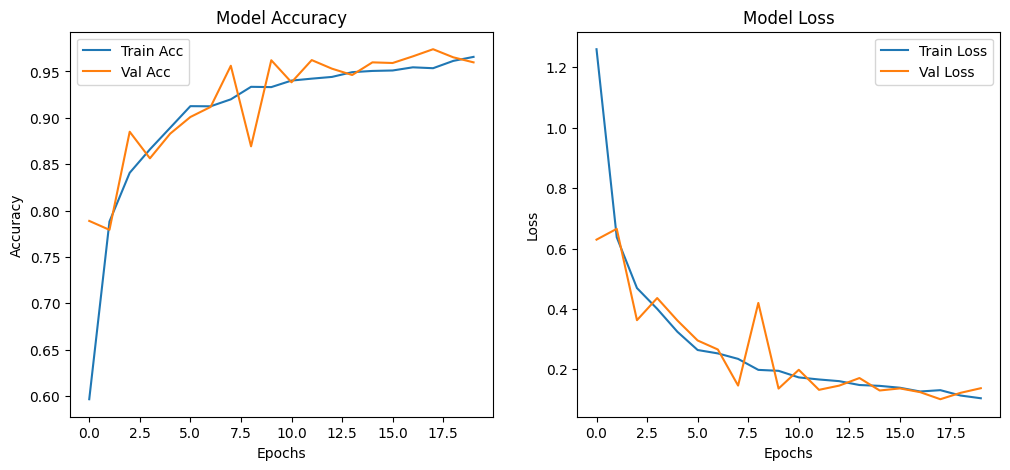

In [9]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

plt.show()


In [12]:
from pathlib import Path

# Create /app/models directory if it doesn't exist
Path("/app/models").mkdir(parents=True, exist_ok=True)
print("✅ /app/models folder is ready")


✅ /app/models folder is ready


In [15]:
model.save("/app/models/plant_disease_cnn.keras")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [10]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc*100:.2f}%")


179/179 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.9706 - loss: 0.0957
Test Accuracy: 97.06%


In [ ]:
import numpy as np

# This works if you still have 'train_data' available from training
class_names = list(train_data.class_indices.keys())

# Make sure the folder exists
from pathlib import Path
Path("/app/models").mkdir(parents=True, exist_ok=True)

# Save labels
np.save("/app/models/class_names.npy", class_names)

print("✅ Class names saved at /app/models/class_names.npy")


✅ Class names saved at /app/models/class_names.npy


In [9]:
!/usr/local/bin/python3 -m pip install tensorflow


  Using cached tensorflow-2.20.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-2.0.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5py-3.15.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (3.0 kB)
  Using cached ml_dtypes-0.5.4-cp313-cp313-macosx_10_13_unive

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load trained model & class names
model = load_model("/app/models/plant_disease_cnn.keras")
class_names = np.load("/app/models/class_names.npy")


# Load and preprocess single image
img = image.load_img("/app/data/processed/test/Tomato_Early_blight/1a8bd88f-309f-4392-b387-7cb423ef0ab6___RS_Erly.B 7366.JPG", target_size=(224, 224))
img_array = np.expand_dims(np.array(img)/255.0, axis=0)

# Predict
pred = model.predict(img_array)
idx = np.argmax(pred)
print("Prediction:", class_names[idx], "| Confidence:", pred[0][idx])


ValueError: File not found: filepath=/app/models/plant_disease_cnn.keras. Please ensure the file is an accessible `.keras` zip file.

In [5]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [7]:
!/usr/local/bin/python3 -m pip show tensorflow
